# Project 1: Detecting Irregular Heart Activity
## Drew Dunkelberger
## MTH 4320

## Problem Description
**Heart arrhythmia** refers to irregularities in a heartbeat. The types considered in this project are:
- Supraventricular ectopic beat (SVEB): An extra heartbeat originating in the higher chamber of the heart (atria)
  - More than 200,000 US cases per year
- Ventricular Ectopic Beat (VEB): An extra heartbeat originating in the lower chamber of the heart
  - More than 3 million US cases per year
- Fusion Beat (F): An extra heartbeast occuring when a supraventricular and a ventricular impulse coincide to produce a hybrid complex

Electro-cardiograms (ECGs) are one of the main methods used to diagnose heart arrhythmias.

### Goal
To create a feed-forward neural network that can classify different classes of heart arrhythmia using the MIT-BIH data set, which is derived from ECG data, despite the limited data available for rare arrhythmias, such as SVEB and fusion beats.

### Strategies Used
- Oversampling
- Use of macro-average as a metric
- Penalized Model

### **MIT-BIH Arrhythmia Dataset**:
- 109446 examples
- 5 categories: ['N': 0, 'S': 1, 'V': 2, 'F': 3, 'Q': 4]
  - 0 = normal (N)
  - 1 = supraventricular ectopic beat (SVEB) 
  - 2 = ventricular ectopic beat (VEB)
  - 3 = fusion beat (F)
  - 4 = unknown beat (Q)

This dataset is composed of time series data, containing 187 heartbeat signals (parameters) per example. The signals are derived from electrocardiogram (ECG) shapes of both normal and abnormal cases. The data is preprocessed and segmented, where each segment represents a heartbeat.

The presence of unknown beats (class 4) makes this problem interesting, since there may not be a common pattern among those examples.

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from time import time
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from scipy.special import expit
from sys import maxsize
from numpy import errstate
import warnings

## Implementation
Let's start by creating a feed-forward neural network that uses **stochastic gradient descent** which accepts a wide variety of hyper-parameters

In [9]:
# This class is for a fully-connected feedforward neural network using stochastic gradient descent
#
# Inputs:
#
#   layers - a list of numbers of neurons in each layer
#
#   alpha - learning rate
#
#   lambda1 - L1 penalty coefficient
#
#   lambda2 - L2 penalty coefficient
#
#   batchSize - size of mini-batches for SGD
#
#   loss - string to choose which loss function to use:
#     'sum-of-squares'
#     'cross-entropy'
#
#   activation - string to choose which activation function to use:
#       'sigmoid'
#       'elu'
#       'relu'
#
#   initialization - a list specifying the initalization
#     ['normal', k] - standard normal random variables divided by k
#     ['uniform', a, b] - uniform random variables between a and b
#     'Nielsen' - standard normal random variables divided by the number of nodes in the next layer
#     ['LeCun', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(3/nodes in previous
#                                        layer) or lower/upper bounds of +/- the same, respectively
#     ['Glorot', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(1/mean of nodes in
#                                         previous and next layers) or lower/upper bounds of +/- the same, respectively
#     ['He', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(6/nodes in previous
#                                     layer) or lower/upper bounds of +/- the same, respectively
#
#   gamma - momentum coefficient (between 0 and 1)

class FeedforwardNeuralNetwork:
    
    def __init__(self, layers, alpha = 0.1, lambda1 = 0, lambda2 = 0, batchSize = 32, loss = 'sum-of-squares', activation = 'sigmoid', initialization = 'normal', gamma=0.0):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # L1 penalty coefficient
        self.lambda1 = lambda1
        
        # L2 penalty coefficient
        self.lambda2 = lambda2
        
        # batch size
        self.batchSize = batchSize

        # momentum parameter
        self.gamma = gamma
        
        # loss function
        self.loss = loss

        self.activation = self.sigmoid
        self.activation_prime = self.sigmoidDerivative
        if activation == 'elu':
            self.activation = self.elu
            self.activation_prime = self.eluDerivative
        elif activation == 'relu':
            self.activation = self.relu
            self.activation_prime = self.reluDerivative
        elif activation != 'sigmoid':
            print("ERROR: Unrecognized activation function option. defaulting to sigmoid")

        # initialize the weights (randomly) -- this is our initial guess for gradient descent
        self.init = initialization
        if initialization[0] == 'normal':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables divided by k
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/initialization[1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/initialization[1])
        elif initialization[0] == 'uniform':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables between a and b
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[-2] + 1, layers[-1])))
        elif initialization == 'Nielsen':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables divided by the number of nodes in the next layer
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/layers[i+1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/layers[-1])
        # LeCun, Glorot, and He initialization
        elif initialization[0] in ['LeCun', 'Glorot', 'He']:
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                
                # define the limit term for normal random variables
                
                # LeCun initialization ("efficient backprop", default initialization in PyTorch)
                if initialization[0] == 'LeCun':
                    limit = np.sqrt(1.0 / layers[i+1])
                    
                # Glorot initialization (default initialization in Keras)
                elif initialization[0] == 'Glorot':
                    mean = (layers[i] + layers[i+1])/2.0
                    limit = np.sqrt(1.0 / mean)
                    
                # He initialization (typically used for very deep nets with PReLU activation)
                elif initialization[0] == 'He':
                    limit = np.sqrt(2.0 / layers[i+1])
                
                # generate the weights
                if initialization[1] == 'normal':
                    self.W.append(np.random.normal(0.0, limit, size=(layers[i] + 1, layers[i + 1] + 1)))
                    
                elif initialization[1] == 'uniform':
                    limit *= np.sqrt(3.0)
                    self.W.append(np.random.uniform(-limit, limit, size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)

            # define the limit term for normal random variables
            if initialization[0] == 'LeCun':
                limit = np.sqrt(1.0 / layers[-2])
                
            elif initialization[0] == 'Glorot':
                mean = (layers[-2] + layers[-1])/2.0
                limit = np.sqrt(1.0 / mean)
                    
            elif initialization[0] == 'He':
                limit = np.sqrt(2.0 / layers[-2])
            
            # initialize the weights
            if initialization[1] == 'normal':
                self.W.append(np.random.normal(0.0, limit, size=(layers[-2] + 1, layers[-1])))
                
            elif initialization[1] == 'uniform':
                limit *= np.sqrt(3.0)
                self.W.append(np.random.uniform(-limit, limit, size=(layers[-2] + 1, layers[-1])))
        
        
    def to_string(self):
        print(f'Hyper-Params- layers: {self.layers}, alpha: {self.alpha}, l1: {self.lambda1}, l2: {self.lambda2}, batchSize: {self.batchSize}, loss: {self.loss}, init: {self.init}\n')

    ################### Define various activation functions and derivatives ###################
    def sigmoid(self, z):
        return 1.0 / (1 + np.exp(-z))

    def elu(self, z, c=1):
        """Exponential Linear Unit, where c is constant > 0."""
        return np.where(z > 0, z, c * (expit(z) - 1))

    def relu(self, z):
        """Rectified Linear Unit"""
        return np.maximum(np.zeros(z.shape), z)  # Element-wise max(0, w)

    def sigmoidDerivative(self, z):
        return z * (1 - z)

    def eluDerivative(self, z, c=1):
        return np.where(z > 0, 1, c * expit(z))

    def reluDerivative(self, z):
        return np.where(z > 0, 1, 0)

    ############################################################################
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, testX, testY, epochs = 10000, update = 1000, printPerformance = True, class_weights={}):
        trainX = X.copy()
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))
        losses = []
        trainAccuracies = []
        testAccuracies = []
        trainY = y
        
        numberOfExamples = X.shape[0]
        
        # use one-hot encoding for the training labels
        y = to_categorical(y)

        # initialize previous-step gradient
        v = []
        for layer in np.arange(0,len(self.W)):
            v.append(np.zeros(self.W[layer].shape))

        # Save class weights for computing weighted loss
        self.class_weights = class_weights
        if self.class_weights:
            print(f'Using loss function {self.loss} with class weights: {self.class_weights}')
        if not self.class_weights:
            print(f'Using loss function {self.loss} without class weights')

        for epoch in np.arange(0,epochs):
            # print(f'At epoch {epoch}')
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    # print(f'Start: Layer {layer} shape: {A[layer].shape}')
                    
                    # feed through one layer and apply activation function
                    net = A[layer].dot(self.W[layer])
                    out = self.activation(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                if self.loss == 'sum-of-squares':
                    D = [error * self.activation_prime(A[-1])]
                    
                if self.loss == 'cross-entropy':
                    D = [error]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.activation_prime(A[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    with np.errstate(divide='ignore', invalid='ignore'):
                       gradient = (A[layer].T.dot(D[layer])
                                    + 2 * (self.lambda2 / numberOfExamples) * self.W[layer]
                                    + (self.lambda1 / numberOfExamples) * np.sign(self.W[layer]))

                    # use momentum (if gamma > 0) to make weight update
                    v[layer] = self.gamma * v[layer] + self.alpha * gradient
                    self.W[layer] -= v[layer]

            # print the loss (or maybe more) each 'update' number of epochs
            if (epoch + 1) % update == 0:
                
                # compute the loss
                loss = self.computeLoss(X,y)

                # if we choose, compute the accuracy (this makes it run slower)
                if printPerformance:
                    predictedY = self.predict(testX)
                    predictedY = predictedY.argmax(axis=1)
                    testAccuracy = accuracy_score(testY, predictedY)           

                    predictedY = self.predict(trainX)
                    predictedY = predictedY.argmax(axis=1)
                    trainAccuracy = accuracy_score(trainY, predictedY)

                    testAccuracies.append(testAccuracy)
                    trainAccuracies.append(trainAccuracy)
                    losses.append(loss)
                    
                    # print('Epoch =', epoch + 1, '\tloss =', loss)
                    
                # otherwise, simply print the training loss
                else:
                    losses.append(loss)
                    # print('Epoch =', epoch + 1, '\tloss =', loss)

        # if we chose to print the performance, plot loss, training accuracy, and test accuracy for each epoch
        if printPerformance:
            
            fig, ax1 = plt.subplots()

            # plot the losses
            p1 = ax1.plot(np.arange(0, epochs, update), losses, label = 'Loss')
            ax1.set_xlabel('Training Epoch')
            ax1.set_ylabel('Loss')

            # make another y axis using the same x axis
            ax2 = ax1.twinx()
            ax2.set_ylim([0.5, 1])
            
            # plot the accuracy
            p2 = ax2.plot(np.arange(0, epochs, update), trainAccuracies, label = 'Accuracy (train)', color = 'tab:orange')
            p3 = ax2.plot(np.arange(0, epochs, update), testAccuracies, label = 'Accuracy (test)', color = 'tab:green')
            ax2.set_ylabel('Accuracy')

            # add a legend
            ps = p1 + p2 + p3
            labs = [p.get_label() for p in ps]
            ax1.legend(ps, labs, loc=0)
            
    # feed data into the network and compute the outputs
    def predict(self, X, addOnes = True):
        
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            p = self.activation(np.dot(p, self.W[layer]))
            
        # return the predictions
        return p
    
    # compute the loss function
    def computeLoss(self, X, y):
        
        # initialize data to the right dimension
        y = np.atleast_2d(y)
        
        # Apply weights to each target in y depending on class
        if (self.class_weights):
            c_weights = np.asarray([self.class_weights[np.argmax(target==1)] for target in y])
            c_weights = (y.T * c_weights).T
            # print(c_weights)
        else:
            c_weights = y
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False)
        
        # if the loss function is sum of squares, compute it
        if self.loss == 'sum-of-squares':
            loss = np.sum((c_weights *(predictions - y))**2) / 2.0
            
        # if the loss function is cross-entropy, compute it
        if self.loss == 'cross-entropy':
            # with warnings.catch_warnings():  # Filter out warnings at every iteration.
            with np.errstate(divide='ignore', invalid='ignore'):
                # warnings.filterwarnings('ignore')
                loss = np.sum(np.nan_to_num(-y*np.log(predictions)-(1-y)*np.log(1-predictions))*c_weights)
        
        # add L1 and L2 penalty
        L1penalty = 0
        L2penalty = 0
        
        # add up L1 and L2 penalties from each layer
        for layer in np.arange(0,len(self.W)):
            L1penalty += np.sum(np.abs(self.W[layer]))
            L2penalty += np.sum(self.W[layer] ** 2)
        
        # L1 and L2 penalties to the loss
        loss += (self.lambda1 / X.shape[0]) * L1penalty
        loss += (self.lambda2 / X.shape[0]) * L2penalty
        
        return loss

## Data Preparation: MIT BIH ECG Database
This data set contains 109,444 examples total, consisting of five different classes sorted in ascending order. For convenience, the data set is already split into a training and testing set in a 4:1 ratio.

Below, I created an auxiliary function to retrieve the training and test data, split it into the X and Y matrices, and scale the data to be from [0, 1.0] rather than [0, 10.0]. I also store the number of parameters as a global variable for reuse throughout experiments and allow specification of a sample from the training data:

In [2]:
global PARAM_COUNT
def get_data(train_sample=None):
    # import the data from the csv file to an numpy array
    test_data = pd.read_csv('data/mitbih_test.csv', sep=',').to_numpy()
    train_data = pd.read_csv('data/mitbih_train.csv', sep=',').to_numpy()
    global PARAM_COUNT
    PARAM_COUNT = test_data.shape[1] - 1              # Number of parameters per example.

    # print(test_data.shape, train_data.shape)#
    if train_sample is None:
        trainX = np.array(train_data[:,0:PARAM_COUNT], dtype=float)
        trainY = np.array(train_data[:,PARAM_COUNT], dtype=int)
    else:
        print(f'Sampling {train_sample} examples from training set')
        # Shuffle training data before sampling
        p = np.arange(0,train_data.shape[0])
        np.random.shuffle(p)
        train_data = train_data[p]
        
        trainX = np.array(train_data[0:train_sample,0:PARAM_COUNT], dtype=float)
        trainY = np.array(train_data[0:train_sample,PARAM_COUNT], dtype=int)

    testX = np.array(test_data[:,0:PARAM_COUNT], dtype=float)
    testY = np.array(test_data[:,PARAM_COUNT], dtype=int)

    # scale the data to values in [0,1]
    trainX = trainX.astype('float32')/10.0
    testX = testX.astype('float32')/10.0

    return (trainX, testX, trainY, testY)

## Benchmark for classification: Logistic Regression

In [8]:
SAMPLE_SIZE = None  # Load entire training set
start_time = time()

warnings.filterwarnings('ignore')
(trainX, testX, trainY, testY) = get_data(train_sample=SAMPLE_SIZE)

print(f'Training data shape (X): {trainX.shape}')
print(f'Testing data shape (X): {testX.shape}')
print(f'Parameters per example: {PARAM_COUNT}')

# Use a simple logistic model to predict
model = LogisticRegression()
model.fit(trainX, trainY)
predictions = model.predict(testX)

print(classification_report(testY, predictions))
end_time = time()
print(f'Time to run: {end_time - start_time:.2f} seconds')

Training data shape (X): (87553, 187)
Testing data shape (X): (21891, 187)
Parameters per example: 187
              precision    recall  f1-score   support

           0       0.90      0.99      0.94     18117
           1       0.27      0.01      0.03       556
           2       0.62      0.22      0.33      1448
           3       0.00      0.00      0.00       162
           4       0.93      0.83      0.88      1608

    accuracy                           0.89     21891
   macro avg       0.54      0.41      0.43     21891
weighted avg       0.86      0.89      0.87     21891

Time to run: 9.28 seconds


Using logistic regression, we get a fairly high accuracy of .89; however, classes 1 and 3 are essentially ignored. Let's use these results as a benchmark for the feedforward neural network's performance.

## Initial Experiment
Here, I ran a few small experiments with different learning rates, loss functions, and activation functions. I found this set to provide fairly decent results:
- Learning rate: .01
- Loss: Cross entropy
- Activation: ReLU

Increasing the learning rate any further resulted in all predictions going to 0.

Training data shape (X): (87553, 187)
Testing data shape (X): (21891, 187)
Parameters per example: 187
Using loss function cross-entropy without class weights
Test set accuracy
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18117
           1       0.96      0.55      0.70       556
           2       0.91      0.86      0.88      1448
           3       0.68      0.40      0.50       162
           4       0.99      0.89      0.94      1608

    accuracy                           0.96     21891
   macro avg       0.90      0.74      0.80     21891
weighted avg       0.96      0.96      0.96     21891



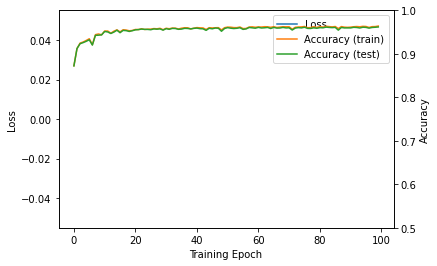

In [11]:
warnings.filterwarnings('ignore')
(trainX, testX, trainY, testY) = get_data()

print(f'Training data shape (X): {trainX.shape}')
print(f'Testing data shape (X): {testX.shape}')
print(f'Parameters per example: {PARAM_COUNT}')

# fit the model to the training data
model = FeedforwardNeuralNetwork([PARAM_COUNT, 16, 8, 5], 0.01, 0.0, 0.0, 32, loss='cross-entropy', activation='relu', initialization='Nielsen')
model.fit(trainX, trainY, testX, testY, 100, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
with np.errstate(divide='ignore', invalid='ignore'):
    print(classification_report(testY, predictedY))

Immediately we have achieved better results than logistic regression for classification. In addition to the overall accuracy being significantly higher, we also see that some of the examples for the under-represented classes are being predicted correctly.

The accuracy for examples in class 3 and class 1 are still much lower than other classes. This is likely because the model is provided very little examples of these classes, and the overall accuracy is merely representative of the distribution of the classes. For example, there are far more examples of class 0 than all of the other classes combined; if the model were to predict all 0s, the accuracy will still be fairly high.

## Making Improvements
In order to quantify equal representation of classes, I used the macro-average (unweighted average) as a metric in experiments.

After doing some research, I found several ways to combat this inbalance in class distribution:
- Resampling data*
  - Under-sampling: Delete examples from over-represented classes in training data
  - Over-sampling: Add copies of examples from under-represented classes in training data
  - Being that the training data in this example consists of tens of thousands of data, either approach would be feasible
    - However, class 3 only has data in the hundreds, extremely small in comparison to other classes. Over-sampling may be better in this case
- Data augmentation
  - Difficult in this case, as I do not know the predictors of each class, nor am I aware of slight variations I can make to numerical data.
  - Easier with image data using rotations, distortion, etc.
- Penalized model*
  - Penalizing errors more in the under-represented classes than over-represented classes
  - Good option if resampling is not feasible


Source: [Tactics to combat imbalanced classes](https://machinelearningmastery.com/tactics-to-combat-imbalanced-classes-in-your-machine-learning-dataset/)


## Resampling the data

Being that this is one of the simplest tactics for aiding with class imbalance, this will be our starting point. Here we will compare under-sampling and over-sampling and see which better improves our performance, using the macro average and overall accuracy as metrics. The goal is to improve accuracy of under-represented classes, while maintaining a fairly high overall accuracy.

### Under-Sampling

class 0 length: 72470
class 1 length: 2223
class 2 length: 5788
class 3 length: 641
class 4 length: 6431
Min length (sample size): 641
Using loss function cross-entropy without class weights
Test set accuracy
              precision    recall  f1-score   support

           0       0.97      0.79      0.87     18117
           1       0.18      0.67      0.28       556
           2       0.53      0.83      0.64      1448
           3       0.12      0.85      0.21       162
           4       0.87      0.89      0.88      1608

    accuracy                           0.79     21891
   macro avg       0.53      0.81      0.58     21891
weighted avg       0.91      0.79      0.83     21891



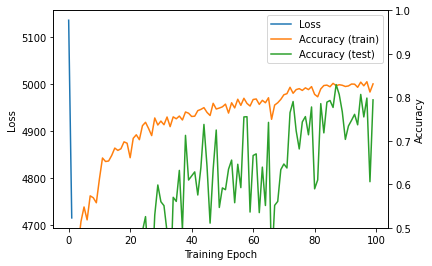

In [12]:
# Get imported data
(trainX, testX, trainY, testY) = get_data()

# Find start index of each class in the sorted array
class_start = np.nonzero(np.r_[1, np.diff(trainY)[:-1]])[0]

# End of data set.
class_start = np.append(class_start, trainY.shape[0])
# print(class_start)

min_len = maxsize
for i in range(1, class_start.size):
    curr_len = class_start[i]-class_start[i-1]
    print(f'class {i-1} length: {curr_len}')
    if curr_len < min_len:
        min_len = curr_len
print(f'Min length (sample size): {min_len}')

# Take first min_len number of examples of each class
sampleY = [trainY[class_start[i]:class_start[i]+min_len] for i in range(0, class_start.size)]
sampleY = np.concatenate(sampleY)
sampleX = [trainX[class_start[i]:class_start[i]+min_len, 0:PARAM_COUNT] for i in range(0, class_start.size)]
sampleX = np.concatenate(sampleX)

# fit the model to the training data
model = FeedforwardNeuralNetwork([PARAM_COUNT, 16, 8, 5], 0.01, 0.0, 0.0, 32, loss='cross-entropy', activation='relu', initialization='Nielsen')
model.fit(sampleX, sampleY, testX, testY, 100, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

Evening out the sample sizes resulted in a worse overall accuracy, but now we can see that the model does predict some examples of the under-represented classes (although with low accuracy). The sheer number of occurences of class 0 in the test data demonstrate why incorrect classifications of 0 have a large affect on the overall accuracy.

Looking at the graph above, the test accuracy is highly erratic... We have a large overfitting problem due to the small total size of the training data.

We can try to resolve this with $L^2$ regularization, but this likely won't help much

Using loss function cross-entropy without class weights
Test set accuracy
              precision    recall  f1-score   support

           0       0.98      0.59      0.73     18117
           1       0.16      0.69      0.26       556
           2       0.28      0.75      0.41      1448
           3       0.06      0.92      0.11       162
           4       0.66      0.89      0.76      1608

    accuracy                           0.62     21891
   macro avg       0.43      0.77      0.45     21891
weighted avg       0.88      0.62      0.70     21891



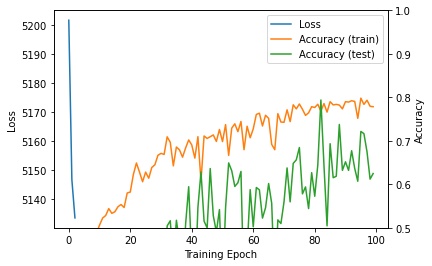

In [13]:
# fit the model to the training data
model = FeedforwardNeuralNetwork([PARAM_COUNT, 8, 8, 8, 5], 0.01, 0.0, .0005, 64, loss='cross-entropy', activation='relu', initialization='Nielsen')
model.fit(sampleX, sampleY, testX, testY, 100, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

As suspected, experimenting with several $L^2$ values did not improve the situation. Unfortunately this data set has a very small number of examples for class 1, making vanilla undersampling infeasible for training. Using extremely small sample sizes of each class leads to comparatively terrible predictions on the test data, since the model does not have enough examples to properly "learn" pattterns. Let's try oversampling instead

### Over-Sampling

In [14]:
# Get imported data
(trainX, testX, trainY, testY) = get_data()

# Find start index of each class in the sorted array
class_start = np.nonzero(np.r_[1, np.diff(trainY)[:-1]])[0]

# End of data set.
class_start = np.append(class_start, trainY.shape[0])

for i in range(1, class_start.size):
    curr_len = class_start[i]-class_start[i-1]
    print(f'class {i-1} length: {curr_len}')

class 0 length: 72470
class 1 length: 2223
class 2 length: 5788
class 3 length: 641
class 4 length: 6431


Since classes 0, 2, and 4 received moderately high accuracies in the initial model, we will leave them alone. Classes 1 and 3 had fairly low accuracies, so let's duplicate some of their data.

Inspecting the length of class sizes above, lets triple class 1 and increase class 3 by ten times to even out the occurences of the "abnormal" heart results and shuffle them back into the training data.

(87553, 187) (87553,)
(97768, 187) (97768,)
Using loss function cross-entropy without class weights
Test set accuracy
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18117
           1       0.80      0.61      0.69       556
           2       0.91      0.81      0.85      1448
           3       0.51      0.81      0.63       162
           4       0.97      0.90      0.94      1608

    accuracy                           0.96     21891
   macro avg       0.83      0.82      0.82     21891
weighted avg       0.96      0.96      0.96     21891



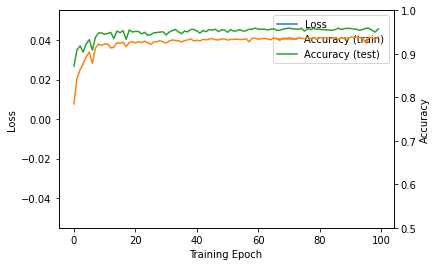

In [15]:
def oversample(X, Y, start):
    class1X = X[start[1]:start[2], 0:PARAM_COUNT]
    class3X = X[start[3]:start[4], 0:PARAM_COUNT]

    # Duplicate data for class 1 and 3
    class1X = np.tile(class1X, (2, 1))
    class3X = np.tile(class3X, (9, 1))
    class1Y = np.ones([class1X.shape[0]], dtype=int)
    class3Y = np.full([class3X.shape[0]], 3)

    # Add duplicated data to training set
    X = np.concatenate((X, class1X, class3X))
    Y = np.concatenate((Y, class1Y, class3Y))

    # randomize the examples
    p = np.arange(0, X.shape[0])
    np.random.shuffle(p)
    X = X[p]
    Y = Y[p]

    return X, Y

# Oversample training data and print shape
print(trainX.shape, trainY.shape)
trainX, trainY = oversample(trainX, trainY, class_start)
print(trainX.shape, trainY.shape)

# fit the model to the training data
model = FeedforwardNeuralNetwork([PARAM_COUNT, 16, 8, 5], 0.01, 0.0, 0.0, 32, loss='cross-entropy', activation='relu', initialization='Nielsen')
model.fit(trainX, trainY, testX, testY, 100, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

Here, we can see that we get the about the **same overall accuracy** as the original set of data AND we see a slightly higher macro-average, implying that the different class classes overall have more equal representation. In fact, the most under-represented class has a higher accuracy (although still relatively low):

- Macro Average: $$.80 \rightarrow .82 $$
- Accuracy of class 1: $$.70 \rightarrow .69$$
- Accuracy of class 3: $$.50 \rightarrow .63$$

Additionally, the test accuracy is higher than the training accuracy! This means that the introduction of duplicate data did not introduce any (significant) overfitting.

That being said, let's add a small amount $L^2$ regularization (.01) to see how the model reacts:

Using loss function cross-entropy without class weights
Test set accuracy
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18117
           1       0.81      0.62      0.70       556
           2       0.95      0.80      0.87      1448
           3       0.57      0.77      0.65       162
           4       0.97      0.90      0.93      1608

    accuracy                           0.96     21891
   macro avg       0.85      0.81      0.83     21891
weighted avg       0.96      0.96      0.96     21891



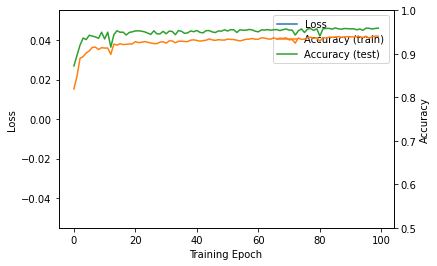

In [16]:
# Get imported data and oversample
(trainX, testX, trainY, testY) = get_data()
class_start = np.nonzero(np.r_[1, np.diff(trainY)[:-1]])[0]
class_start = np.append(class_start, trainY.shape[0])
trainX, trainY = oversample(trainX, trainY, class_start)

# fit the model to the training data
model = FeedforwardNeuralNetwork([PARAM_COUNT, 16, 8, 5], 0.01, 0.0, 0.01, 32, loss='cross-entropy', activation='relu', initialization='Nielsen')
model.fit(trainX, trainY, testX, testY, 100, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

Adding a small amount of regularization didn't change much in terms of the overall accuracy, but the macro average became .83. Let's try a larger value of 1:

Using loss function cross-entropy without class weights
Test set accuracy
              precision    recall  f1-score   support

           0       0.83      1.00      0.91     18117
           1       0.00      0.00      0.00       556
           2       0.00      0.00      0.00      1448
           3       0.00      0.00      0.00       162
           4       0.00      0.00      0.00      1608

    accuracy                           0.83     21891
   macro avg       0.17      0.20      0.18     21891
weighted avg       0.68      0.83      0.75     21891



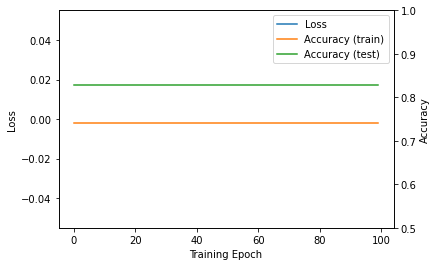

In [17]:
(trainX, testX, trainY, testY) = get_data()
class_start = np.nonzero(np.r_[1, np.diff(trainY)[:-1]])[0]
class_start = np.append(class_start, trainY.shape[0])
trainX, trainY = oversample(trainX, trainY, class_start)

# fit the model to the training data
model = FeedforwardNeuralNetwork([PARAM_COUNT, 16, 8, 5], 1, 0.0, 0.01, 32, loss='cross-entropy', activation='relu', initialization='Nielsen')
model.fit(trainX, trainY, testX, testY, 100, 1)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

Adding a  $L^2$ too large, resulting in all predictions going to zero... 

As expected, adding $L^2$ regularization does not seem to benefit the model very much. Let's proceed to tuning without worry of $L^2$ regularization.

## Tuning Hyperparameters on Over-sampled Data Set
Now that we are able to predict better for some of the under-represented classes, let's try to tune hyper-parameters for better results using the macro average (unweighted) as our metric to ensure better representation of all classes.

For tuning, we will adjust the network architecture and two loss functions to find an optimum combination and hopefully reduce overfitting. For the sake of time, we will use only 50 epochs per hyperparameter set

In [32]:
from sklearn.metrics import f1_score

# Get imported data
(trainX, testX, trainY, testY) = get_data()

# Randomly split data into a train/dev/test sets in approx. 60/20/20 split
(trainX, devX, trainY, devY) = train_test_split(trainX, trainY, test_size=.75, random_state=1)

# Sort the training data in order of classes
p = trainY.argsort()
print(f'Permutation: {p}')
trainY = trainY[p]
trainX = trainX[p]

# Find start index of each class in the sorted array
class_start = np.nonzero(np.r_[1, np.diff(trainY)[:-1]])[0]
class_start = np.append(class_start, trainY.shape[0])
print(f'Class starts: {class_start}')

# Print length of each class
for i in range(1, class_start.size):
    curr_len = class_start[i]-class_start[i-1]
    print(f'class {i-1} length: {curr_len}')

# Oversample training data ONLY, after split
trainX, trainY = oversample(trainX, trainY, class_start)

print(f'Train: {trainX.shape}\nTest: {testX.shape}\nDev: {devX.shape}')

# Track best hyperparameter set
best_hyperparameters = [0, 0]
best_macro_avg = 0
count = 0

for layers in [[PARAM_COUNT, 16, 8, 5], [PARAM_COUNT, 32, 5], [PARAM_COUNT, 32, 16, 5], [PARAM_COUNT, 32, 16, 8, 5]]:
    for loss in ['cross-entropy', 'sum-of-squares']:
        count += 1
        print(f'## Run {count} ##')

        # fit the model to the training data
        model = FeedforwardNeuralNetwork(layers, 0.01, 0.0, 0.0, 32, loss=loss, activation='relu', initialization='Nielsen')
        model.fit(trainX, trainY, devX, devY, 50, 1, False)

        # Predict against dev set
        itr_devY = devY.copy()
        predictedY = model.predict(devX)
        predictedY = predictedY.argmax(axis=1)

        # Get macro average
        curr_macro_avg = f1_score(itr_devY, predictedY, average='macro')

        itr_devY = to_categorical(itr_devY)
        itr_devY = itr_devY.argmax(axis=1)

        if curr_macro_avg > best_macro_avg:
            best_macro_avg = curr_macro_avg
            best_hyperparameters = [layers, loss]
        print(f'Layers: {layers}, Loss: {loss}, Macro Avg={curr_macro_avg}')
print('############################## Best Hyper-Parameters ##############################')
print(f'Layers: {best_hyperparameters[0]}, Loss: {best_hyperparameters[1]}, Macro Avg={best_macro_avg}')

# Save best hyperparameters
best_layers = best_hyperparameters[0]
best_loss = best_hyperparameters[1]

Permutation: [    0 13896 13895 ...  8069  8017 18336]
Class starts: [    0 18090 18656 20098 20282 21888]
class 0 length: 18090
class 1 length: 566
class 2 length: 1442
class 3 length: 184
class 4 length: 1606
Train: (24676, 187)
Test: (21891, 187)
Dev: (65665, 187)
## Run 1 ##
Using loss function cross-entropy without class weights
Layers: [187, 16, 8, 5], Loss: cross-entropy, Macro Avg=0.7635502302297633
## Run 2 ##
Using loss function sum-of-squares without class weights
Layers: [187, 16, 8, 5], Loss: sum-of-squares, Macro Avg=0.47767410118933284
## Run 3 ##
Using loss function cross-entropy without class weights
Layers: [187, 32, 5], Loss: cross-entropy, Macro Avg=0.7670351289180394
## Run 4 ##
Using loss function sum-of-squares without class weights
Layers: [187, 32, 5], Loss: sum-of-squares, Macro Avg=0.781382300880856
## Run 5 ##
Using loss function cross-entropy without class weights
Layers: [187, 32, 16, 5], Loss: cross-entropy, Macro Avg=0.7809351662682196
## Run 6 ##
Using 

Here, we can see that the sum-of-squares loss function tended to perform better than cross-entropy, as well as relatively complex network architectures over simpler ones.

Using loss function sum-of-squares without class weights
Test set accuracy
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18117
           1       0.93      0.57      0.71       556
           2       0.94      0.86      0.90      1448
           3       0.64      0.69      0.66       162
           4       0.98      0.93      0.96      1608

    accuracy                           0.97     21891
   macro avg       0.89      0.81      0.84     21891
weighted avg       0.97      0.97      0.97     21891



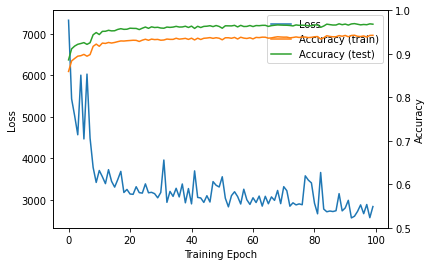

In [33]:
# Get imported data
(trainX, testX, trainY, testY) = get_data()

# Oversample training data
trainX, trainY = oversample(trainX, trainY, class_start)

# fit the model to the training data
model = FeedforwardNeuralNetwork(best_hyperparameters[0], 0.01, 0.0, 0.0, 32, loss=best_hyperparameters[1], activation='relu', initialization='Nielsen')
model.fit(trainX, trainY, testX, testY, 100, 1, True)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
with np.errstate(divide='ignore', invalid='ignore'):
    print(classification_report(testY, predictedY))

Using the tuned hyper-parameters, we get a slightly higher accuracy of .97 AND a better macro average of .84. Let's try another strategy to improve the macro average further below

## Using a penalized model

So far I have implemented a *data-level* strategy to address class imbalance. Now I will add an *algorithm-level* strategy by implementing a **penalized model** which favors under-represented classes by penalizing errors in them heavier than errors in over-represented (low entropy) classes.

To do this, I multiplied the loss by class weights, using the inverse of the class distributions as outlined in [this article](https://machinelearningmastery.com/cost-sensitive-neural-network-for-imbalanced-classification/). This is not a perfect solution, but hopefully it will give better results by taking into account the class distribution of the training set.


To implement this, we will calculate the **inverse** of the class distribution and multiply the loss by the class weight corresponding to a particular example. Thus, less frequent classes will have a larger weight, signifying that they are more important and such errors are penalized heavier. Here is a code snippet in **computeLoss()** before calculating the loss:
```
# Apply weights to each target in y depending on class
if (self.class_weights):
    c_weights = np.asarray([self.class_weights[np.argmax(target==1)] for target in y])
    c_weights = (y.T * c_weights).T
    # print(c_weights)
else:
    c_weights = y
```

Here, c_weights (same shape as y) is multiplied by the loss function at each update epoch. The values of class_weights are calculated below:

### Penalized Model without Oversampling

Using loss function sum-of-squares with class weights: {0: 1, 1: 39, 2: 15, 3: 137, 4: 14}
Test set accuracy
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18117
           1       0.98      0.53      0.69       556
           2       0.92      0.88      0.90      1448
           3       0.86      0.34      0.49       162
           4       1.00      0.90      0.94      1608

    accuracy                           0.97     21891
   macro avg       0.94      0.73      0.80     21891
weighted avg       0.97      0.97      0.96     21891



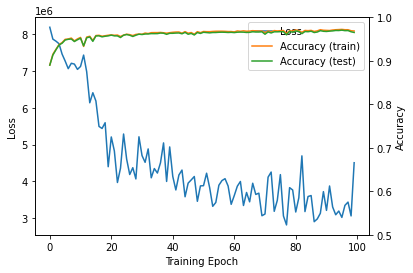

In [20]:
# Get imported data
(trainX, testX, trainY, testY) = get_data()

# Find start index of each class in the sorted array
class_start = np.nonzero(np.r_[1, np.diff(trainY)[:-1]])[0]
class_start = np.append(class_start, trainY.shape[0])

# Weight each class by inverse distribution, rounded to nearest int
class_weights = {}
total_size = trainY.shape[0]
# Get unique classes in y, along with their frequencies
uniques, counts = np.unique(trainY.T, return_counts=True)
# Map each class to inverse distribution
class_weights = dict(zip(uniques, np.rint(total_size / counts).astype(int)))

model = FeedforwardNeuralNetwork(best_hyperparameters[0], 0.01, 0.0, 0.0, 32, loss=best_hyperparameters[1], activation='relu', initialization='Nielsen')

# Fit model with class weights
model.fit(trainX, trainY, testX, testY, 100, 1, True, class_weights)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
with np.errstate(divide='ignore', invalid='ignore'):
    print(classification_report(testY, predictedY))

Here, we see that the penalized model alone provides a better overall accuracy than our benchmark; however, without oversampling, the accuracies of the under-represented classes suffer. Next, I tried combinining the two strategies

### Penalized Model with Oversampling (after class weight calculation)

Here, I made use of both strategies by calculating the inverse class distribution weight BEFORE I oversampled the data. This increased the frequency of examples for under-represented classes without diminishing the "importance" of under-represented classes in the loss caclulation

Using loss function sum-of-squares with class weights: {0: 1, 1: 39, 2: 15, 3: 137, 4: 14}
Test set accuracy
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18117
           1       0.82      0.66      0.73       556
           2       0.94      0.85      0.89      1448
           3       0.67      0.77      0.72       162
           4       0.99      0.91      0.95      1608

    accuracy                           0.97     21891
   macro avg       0.88      0.84      0.85     21891
weighted avg       0.97      0.97      0.97     21891



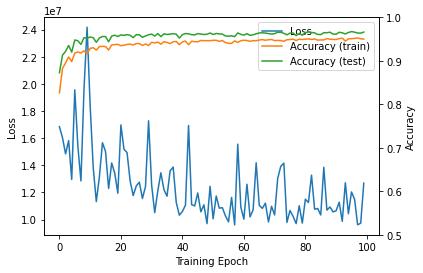

In [21]:
# Get imported data
(trainX, testX, trainY, testY) = get_data()

# Find start index of each class in the sorted array
class_start = np.nonzero(np.r_[1, np.diff(trainY)[:-1]])[0]
class_start = np.append(class_start, trainY.shape[0])

# Weight each class by inverse distribution, rounded to nearest int
class_weights = {}
total_size = trainY.shape[0]
# Get unique classes in y, along with their frequency
uniques, counts = np.unique(trainY.T, return_counts=True)
# Map each class to inverse distribution
class_weights = dict(zip(uniques, np.rint(total_size / counts).astype(int)))

# Oversample training data AFTER calculation inverse class distributionCom
trainX, trainY = oversample(trainX, trainY, class_start)

model = FeedforwardNeuralNetwork(best_hyperparameters[0], 0.01, 0.0, 0.0, 32, loss=best_hyperparameters[1], activation='relu', initialization='Nielsen')

# Fit model with class weights
model.fit(trainX, trainY, testX, testY, 100, 1, True, class_weights)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
with np.errstate(divide='ignore', invalid='ignore'):
    print(classification_report(testY, predictedY))

Combining the two methods provided the best results thus far; the accuracy increased to .97 AND the macro average increased to .85

Next, I tried tuning different hyper-parameters with these previously best ones, using *both* the **penalized model** and **oversampling**. Since overfitting wasn't a problem, I chose to vary weight initialization and momentum rather than any regularization, to see if I could optimize the model

## Tuning Hyperparameters with a Penalized Model and Oversampling

### Tuning Weight Initialization and Momentum

In [25]:
from sklearn.metrics import f1_score

# Get imported data
(trainX, testX, trainY, testY) = get_data()

# Randomly split data into a train/dev/test sets in approx. 60/20/20 split
(trainX, devX, trainY, devY) = train_test_split(trainX, trainY, test_size=.75, random_state=1)

# Sort the training data in order of classes
p = trainY.argsort()
trainY = trainY[p]
trainX = trainX[p]

# Find start index of each class in the sorted array
class_start = np.nonzero(np.r_[1, np.diff(trainY)[:-1]])[0]
class_start = np.append(class_start, trainY.shape[0])

# Weight each class by inverse distribution
class_weights = {}
total_size = trainY.shape[0]
uniques, counts = np.unique(trainY.T, return_counts=True)
class_weights = dict(zip(uniques, np.rint(total_size / counts).astype(int)))

# Oversample training data AFTER calculation inverse class distributionCom
trainX, trainY = oversample(trainX, trainY, class_start)

best_hyperparameters = [0, 0]
best_macro_avg = 0
count = 0

for weight_init in ['Nielsen', ['LeCun', 'uniform'], ['Glorot', 'uniform'], ['He', 'normal']]:
    for gamma in [0, 0.1, .5, .9]:
        count += 1
        print(f'## Run {count} ##')

        # fit the model to the training data
        model = FeedforwardNeuralNetwork([PARAM_COUNT, 32, 16, 5], 0.01, 0.0, 0.0, 32,
                loss='sum-of-squares', activation='relu', initialization=weight_init, gamma=gamma)
        model.fit(trainX, trainY, devX, devY, 50, 1, False, class_weights)

        # Predict against dev set
        itr_devY = devY.copy()
        predictedY = model.predict(devX)
        predictedY = predictedY.argmax(axis=1)

        # Get macro average
        curr_macro_avg = f1_score(itr_devY, predictedY, average='macro')

        itr_devY = to_categorical(itr_devY)
        itr_devY = itr_devY.argmax(axis=1)

        if curr_macro_avg > best_macro_avg:
            best_macro_avg = curr_macro_avg
            best_hyperparameters = [weight_init, gamma]
        print(f'Weight Init: {weight_init}, Momentum: {gamma}, Macro Avg={curr_macro_avg}')
print('############################## Best Hyper-Parameters ##############################')
print(f'Weight Init: {best_hyperparameters[0]}, Momentum: {best_hyperparameters[1]}, Macro Avg={best_macro_avg}')

## Run 1 ##
Using loss function sum-of-squares with class weights: {0: 1, 1: 39, 2: 15, 3: 119, 4: 14}
Weight Init: Nielsen, Momentum: 0, Macro Avg=0.8160603892745689
## Run 2 ##
Using loss function sum-of-squares with class weights: {0: 1, 1: 39, 2: 15, 3: 119, 4: 14}
Weight Init: Nielsen, Momentum: 0.1, Macro Avg=0.7853721028604628
## Run 3 ##
Using loss function sum-of-squares with class weights: {0: 1, 1: 39, 2: 15, 3: 119, 4: 14}
Weight Init: Nielsen, Momentum: 0.5, Macro Avg=0.8011267483190789
## Run 4 ##
Using loss function sum-of-squares with class weights: {0: 1, 1: 39, 2: 15, 3: 119, 4: 14}
Weight Init: Nielsen, Momentum: 0.9, Macro Avg=0.35979221283956
## Run 5 ##
Using loss function sum-of-squares with class weights: {0: 1, 1: 39, 2: 15, 3: 119, 4: 14}
Weight Init: ['LeCun', 'uniform'], Momentum: 0, Macro Avg=0.8110854632110154
## Run 6 ##
Using loss function sum-of-squares with class weights: {0: 1, 1: 39, 2: 15, 3: 119, 4: 14}
Weight Init: ['LeCun', 'uniform'], Momentum: 

Here, we see that the model tends to perform better in terms of the macro-average with some amount of momentum, depending on the weight initialization

### Testing Tuned Hyperparameters on Penalized Model with Oversampling

Using loss function sum-of-squares with class weights: {0: 1, 1: 39, 2: 15, 3: 137, 4: 14}
Test set accuracy
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     18117
           1       0.83      0.63      0.72       556
           2       0.95      0.84      0.89      1448
           3       0.61      0.75      0.67       162
           4       0.98      0.93      0.96      1608

    accuracy                           0.97     21891
   macro avg       0.87      0.83      0.84     21891
weighted avg       0.97      0.97      0.97     21891



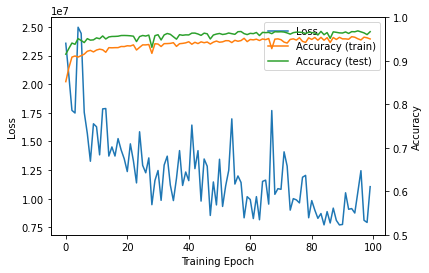

In [26]:
# Get imported data
(trainX, testX, trainY, testY) = get_data()

# Find start index of each class in the sorted array
class_start = np.nonzero(np.r_[1, np.diff(trainY)[:-1]])[0]
class_start = np.append(class_start, trainY.shape[0])

# Weight each class by inverse distribution
class_weights = {}
total_size = trainY.shape[0]
uniques, counts = np.unique(trainY.T, return_counts=True)
class_weights = dict(zip(uniques, np.rint(total_size / counts).astype(int)))

# Oversample training data AFTER calculation inverse class distributionCom
trainX, trainY = oversample(trainX, trainY, class_start)

model = FeedforwardNeuralNetwork([PARAM_COUNT, 32, 16, 5], 0.01, 0.0, 0.0, 32, loss='sum-of-squares', activation='relu',
                                 initialization=best_hyperparameters[0], gamma=best_hyperparameters[1])
model.fit(trainX, trainY, testX, testY, 100, 1, True, class_weights)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
with np.errstate(divide='ignore', invalid='ignore'):
    print(classification_report(testY, predictedY))

Tuning the hyperparameters, we see about the same results as before tuning. Let's try the penalized model alone with the tuned hyperparameters for comparison

### Testing Tuned Hyperparameters for Penalized Model without Oversampling

Using loss function sum-of-squares with class weights: {0: 1, 1: 39, 2: 15, 3: 137, 4: 14}
Test set accuracy
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     18117
           1       0.97      0.55      0.70       556
           2       0.91      0.88      0.89      1448
           3       0.00      0.00      0.00       162
           4       1.00      0.90      0.95      1608

    accuracy                           0.96     21891
   macro avg       0.77      0.67      0.70     21891
weighted avg       0.96      0.96      0.96     21891



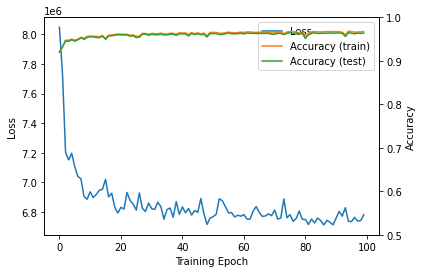

In [27]:
# Get imported data
(trainX, testX, trainY, testY) = get_data()

# Find start index of each class in the sorted array
class_start = np.nonzero(np.r_[1, np.diff(trainY)[:-1]])[0]
class_start = np.append(class_start, trainY.shape[0])

# Weight each class by inverse distribution
class_weights = {}
total_size = trainY.shape[0]
uniques, counts = np.unique(trainY.T, return_counts=True)
class_weights = dict(zip(uniques, np.rint(total_size / counts).astype(int)))

model = FeedforwardNeuralNetwork([PARAM_COUNT, 32, 16, 5], 0.01, 0.0, 0.0, 32, loss='sum-of-squares', activation='relu',
                                 initialization=best_hyperparameters[0], gamma=best_hyperparameters[1])
model.fit(trainX, trainY, testX, testY, 100, 1, True, class_weights)

print("Test set accuracy")
testY = to_categorical(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
with np.errstate(divide='ignore', invalid='ignore'):
    print(classification_report(testY, predictedY))

Here, I received worse results than the combination of penalization and oversampling, as class 3 is ignored completely.

## Conclusion

In conclusion, this data set suffered from a large class imbalance; this is common when dealing with rare occurences. I compared several methods to try and handle this issue: under-sampling, over-sampling, use of macro-average as a metric, and varying penalization by class. A combination of over-sampling and a penalized model was the most effective method in dealing with this issue. 

The best results achieved included a **overall accuracy of .97 with a macro average of .85**. The resulting accuracies for the 2 under-represented classes were at least .70; a major improvement from the original accuracies of .50 and .70 in the inital model. 

Hyperparameters used:
> layers=[187, 32, 16, 5], alpha=0.01, l1=0.0, l2=0.0, batch_size=32, loss='sum-of-squares', activation='relu', initialization='Nielsen'

With more time, one potential strategy that could have improved results is the use of a variational auto-encoder (VAE) for data augmentation.

VAEs are essentially autoencoders that regularize their training to avoid overfitting and "generate" more data that can be used for training another network. This augmentation for under-represented classes in the training data would likely improve the accuracy of those classes for this model.

Given that the overall accuracy was fairly high with the initial set of hyperparameters, the largest roadblock in this project was the lack of available data for the under-represented classes. This problem highlights the significance of class imbalance in real-world data. It can be extremeley difficult to recognize patterns for something that does not occur very often or for which their is limited data. 